In [4]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  
from GPyOpt.methods import BayesianOptimization

Neural Network Model for Hyper Parameter Tuning

In [5]:
def benchmark(X, Y):
    return -(20 * (1 - np.exp(-0.2 * np.sqrt(0.5 * (X**2 + Y**2)))) - np.exp(0.5 * (np.cos(2 * np.pi * X) + np.cos(2 * np. pi * Y))) + np.exp(1))


In [6]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 10

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [7]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, y, a, b: 0.1 * (a - 4) * x + 0.05 * (b + 3) * y**2 + 0.03 * x * y + r.normal(0, sim_stdev)

In [8]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-35, 35, pretrain_n)
Y = np.random.uniform(-35, 35, pretrain_n)

# Calculate the outputs using Himmelblau's Function
output1 = benchmark(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset of Physical Experiments
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [9]:
sim_eval = lambda x, y, a, b: benchmark(x, y) + sim_err(x, y, a, b)

In [10]:
df

,x,y,z
0,-5.808460,-5.656384,-15.447675
1,15.422715,12.965365,-20.539782
2,-34.991994,-20.688343,-21.311133
3,-13.836720,26.468221,-21.753684
4,-24.727088,-33.082868,-21.133971
5,-28.536298,11.932726,-21.439708
6,-21.961785,-5.788664,-20.096030
7,-10.810749,4.108288,-17.005695
8,-7.226277,-25.172914,-20.852178
9,2.717171,-21.132896,-20.500723


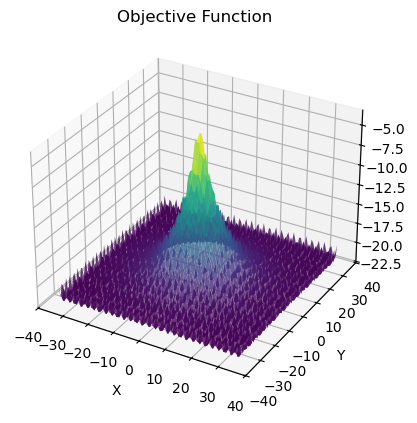

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-35, 35, 100)
y_range = np.linspace(-35, 35, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = benchmark(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Objective Function')

# Show the plot
plt.show()

In [12]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [13]:
# Define the known global maxima for the Himmelblau's function
global_maxima_points = [
    {"X": 0, "Y":  0, "Z": benchmark(0,  0)},
]

# Create a DataFrame for the global maxima
global_maxima_df = pd.DataFrame(global_maxima_points)
global_maxima_df

,X,Y,Z
0,0,0,-0.0


In [ ]:
def perform_iteration(df):

    def sim_all(x):
        df["a"] = x[0,0]
        df["b"] = x[0,1]
        df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
        df["diff"] = df["z"] - df["sim_z"]
        return (df["diff"]**2).sum()

    bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
            {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

    # Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
    bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
    bo.run_optimization(max_iter=max_bo_iter)
    df["a"] = bo.x_opt[0]
    df["b"] = bo.x_opt[1]
    print(bo.x_opt)

    # Create the grid of input values
    x_range = np.linspace(-35, 35, 100)
    y_range = np.linspace(-35, 35, 100)
    x_grid, y_grid = np.meshgrid(x_range, y_range)
    sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

    # Create the plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

    # Customize the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('True Function with Simulation Calibrated Errors')

    # Show the plot
    plt.show()

    # Generate 15 points using Latin Hypercube Sampling (LHS)
    n_samples = 90
    lhs= qmc.LatinHypercube(d=2, optimization="random-cd")
    lhs_samples = lhs.random(n=n_samples)
    bounds = np.array([[-35, 35], [-35, 35]])  # Bounds for Design Space

    scaled_samples = qmc.scale(lhs_samples, bounds[:, 0], bounds[:, 1])

    selected_points_df = pd.DataFrame(scaled_samples, columns=['x', 'y'])
    selected_points_df['sim_z'] = sim_eval(selected_points_df['x'], selected_points_df['y'], bo.x_opt[0], bo.x_opt[1])

    sim_df = df[["x", "y", "sim_z"]]
    sim_df = pd.concat([sim_df, selected_points_df], axis=0, ignore_index=True)
    
    # # Define the objective function to minimize
    # @use_named_args(hyp_space)
    # def objective(**params):
    #     num_layers = params['num_layers']
    #     num_units = params['num_units']
    #     learning_rate = params['learning_rate']
    #     dropout_rate = params['dropout_rate']
    #     batch_size = params['batch_size']
    #     epochs = params['epochs']

    #     model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
    #     # Define K-fold cross-validation
    #     kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    #     scores = []

    #     # Perform cross-validation
    #     for train_idx, val_idx in kfold.split(df[['x', 'y']]):
    #         X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
    #         y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

    #         # Standardize the features
    #         scaler_x = StandardScaler().fit(X_train)
    #         X_train_scaled = scaler_x.transform(X_train)
    #         X_val_scaled = scaler_x.transform(X_val)

    #         # Train the model
    #         model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

    #         # Evaluate the model
    #         score = model.evaluate(X_val_scaled, y_val, verbose=0)
    #         scores.append(score)
    
    #     return np.mean(scores)

    # # Perform Bayesian optimization
    # result = gp_minimize(objective, hyp_space, n_calls=75, random_state=0, acq_func='EI')

    # # Output best hyperparameters from BayesOpt
    # print("Best hyperparameters:")
    # print("num_layers:", result.x[0])
    # print("num_units:", result.x[1])
    # print("learning_rate:", result.x[2])
    # print("dropout_rate:", result.x[3])
    # print("batch_size:", result.x[4])
    # print("epochs:", result.x[5])

    # Train the model with the best hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=6,
        num_units=300,
        learning_rate=0.0007,
        dropout_rate=0.5
    )

    # Standardize the Dataset of Simulation Responses
    scaler= StandardScaler().fit(sim_df[['x', 'y']])
    X_scaled = scaler.transform(sim_df[['x', 'y']])

    # Train the best model on the combined standardized dataset
    best_model.fit(X_scaled, sim_df[['sim_z']], epochs=500, batch_size=150, verbose=1)

    # Create a meshgrid and combine into a single array
    xy_grid = np.c_[x_grid.ravel(), y_grid.ravel()]

    # Perform MC Dropout predictions on the entire grid
    xy_grid_scaled = scaler.transform(xy_grid)
    pred_mean, pred_std = mc_dropout_predictions(best_model, xy_grid_scaled)

    # Ploting mean predictions and confidence intervals
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshaping predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x_grid.shape)
    pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x_grid.shape)
    pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x_grid.shape)

    mean_surface = ax.plot_surface(x_grid, y_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    upper_surface = ax.plot_surface(x_grid, y_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    lower_surface = ax.plot_surface(x_grid, y_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Customize the plot
    ax.set_title('Neural Network of Simulated Response with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    legend_elements = [mean_surface, upper_surface, lower_surface]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.show()
    
    x_range = [(-35, 35)]
    y_range = [(-35, 35)]
    def p_nn(xy):
        xy = np.array(xy).reshape(1, -1)  # Ensure correct shape (1,2)
        xy_scaled = scaler.transform(xy)
        pred_mean, pred_std = mc_dropout_predictions(best_model, xy_scaled)
        # Check if the point is inside the valid domain
        if (x_range[0][0] <= xy[0, 0] <= x_range[0][1] and 
                y_range[0][0] <= xy[0, 1] <= y_range[0][1]):
            return max(pred_mean + 1.96 * pred_std - sim_df["sim_z"].median(), 0)
        else:
            return 1e-10


    def metropolis_step(xy, sig):
        prop_xy = xy + np.random.normal(0, sig, size=xy.shape)  # Generate a candidate

        # Ensure proposed point is inside the valid bounds
        if not (x_range[0][0] <= prop_xy[0, 0] <= x_range[0][1] and 
                y_range[0][0] <= prop_xy[0, 1] <= y_range[0][1]):
            return xy  # Reject out-of-bounds proposals

        u = np.random.uniform(0, 1)
        if u < min(1.0, p_nn(prop_xy) / p_nn(xy)):
            return prop_xy  # Accept move
        else:
            return xy  # Stay at current point


    def mh_sampler(sig, sample_size, burn_in, lag, min_distance=5):
        # Start at the point with the largest simulated response
        max_idx = np.argmax(sim_df["sim_z"])
        x_init = sim_df["x"].iloc[max_idx]
        y_init = sim_df["y"].iloc[max_idx]
        xy = np.array([[x_init, y_init]])
        existing_points = np.array(df[['x', 'y']])

        def is_too_close(new_point, existing_points, min_distance):
            distances = np.sqrt(np.sum((existing_points - new_point) ** 2, axis=1))
            return np.any(distances < min_distance)

        for i in range(burn_in):
            xy = metropolis_step(xy, sig)

        output = xy
        while len(output) < sample_size:
            for j in range(lag):
                xy = metropolis_step(xy, sig)

            if not is_too_close(xy, existing_points, min_distance):
                output = np.vstack((output, xy))
                existing_points = np.vstack((existing_points, xy))  # Update the existing points array

        return output

    max_idx = np.argmax(sim_df["sim_z"])
    x_max = sim_df["x"].iloc[max_idx]
    y_max = sim_df["y"].iloc[max_idx]
    max_point = np.array([[x_max, y_max]])

    X_mh = mh_sampler(sig=5, sample_size=pretrain_n - 1, burn_in=50, lag=20)

    X_all = np.vstack([max_point, X_mh])

    physical_test_points = pd.DataFrame(X_all, columns=["x", "y"])

    # Generate predictions for the heatmap
    pred_mean_grid = pred_mean.reshape(x_grid.shape)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    heatmap = plt.contourf(x_grid, y_grid, pred_mean_grid, cmap='viridis', levels=50)
    plt.colorbar(heatmap, label="Neural Network Response")

    # Overlay sampled points
    plt.scatter(sim_df['x'], sim_df['y'], color='white', edgecolor='black', label='Simulation Sampled Points')
    plt.scatter(physical_test_points['x'], physical_test_points['y'], color='purple', edgecolor='black', label='Next Physical Test Points')

    # Customize the plot
    plt.title("Heatmap of Neural Network Response")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()

    # Add validated data points to original data frame
    physical_test_points["z"] = benchmark(physical_test_points['x'], physical_test_points['y']) + ran_err(pretrain_n, 0.05)
    physical_test_points["a"] = bo.x_opt[0]
    physical_test_points["b"] = bo.x_opt[1]
    physical_test_points["sim_z"] = sim_eval(physical_test_points["x"], physical_test_points["y"], physical_test_points["a"], physical_test_points["b"])
    physical_test_points["diff"] = physical_test_points["z"] - physical_test_points["sim_z"]

    # Heatmap of Simulated Points 
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the heatmap for sim_z_grid
    heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

    # Overlay scatter points for sampling points
    ax.scatter(df["x"], df["y"], color='blue', marker='o', label='Previous Sampled Points')
    ax.scatter(sim_df["x"], sim_df["y"], edgecolor='black', facecolors='none', marker='o', label='Sampled Simulation Points')
    ax.scatter(physical_test_points["x"], physical_test_points["y"], color='purple', marker='o', label='Next Physical Test Points')

    # Overlay scatter points for global maxima
    ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Point')

    # Customize the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
    ax.legend()

    # Add a color bar
    cbar = plt.colorbar(heatmap, ax=ax)
    cbar.set_label('Function Value (Z)')

    # Show the plot
    plt.show()

    # Add points to original dataframe
    df = pd.concat([df, physical_test_points], axis=0, ignore_index=True)

    return df

[ 6.6764216  -3.03884182]


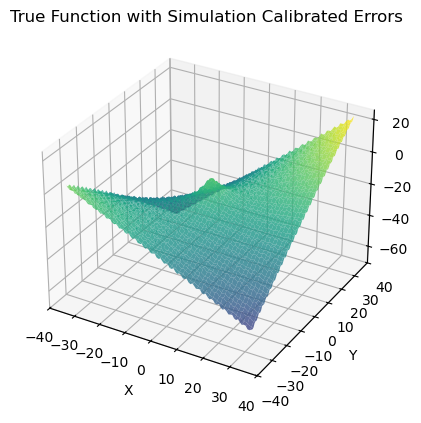

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 746.9998
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 743.2299
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 740.4903
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 736.4875
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 729.8258
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 725.9517
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 719.1214
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 707.1281
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 690.3743
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 678.0057
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 649.3234
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 631.1046
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 586.4978
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 538.9068
Epoch 15/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 

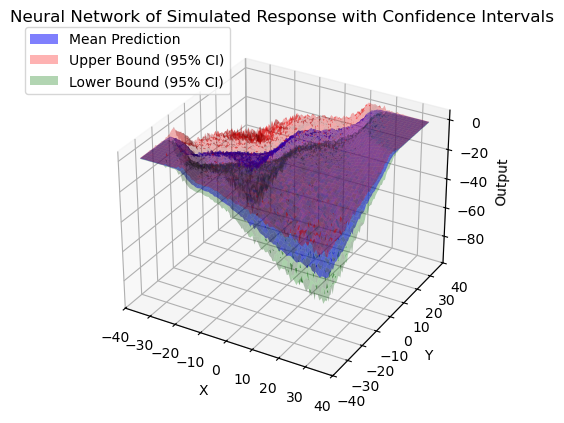

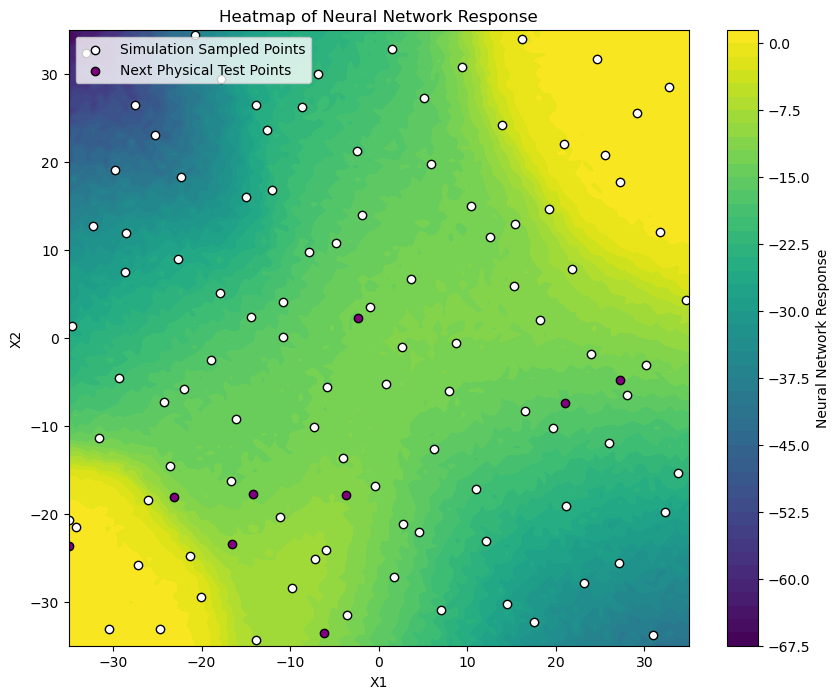

ValueError: operands could not be broadcast together with shapes (9,) (10,) 

In [15]:
df = perform_iteration(df)
print(df)


[ 7.65467132 -3.24417383]


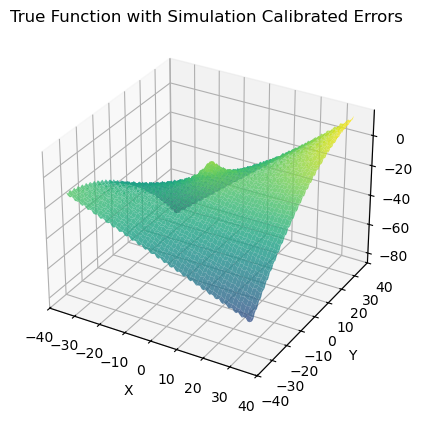

Best hyperparameters:
num_layers: 5
num_units: 200
learning_rate: 0.0007242105458545238
dropout_rate: 0.5
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1961.4803
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1951.4312
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1947.8489
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1940.3939
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1933.2418
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1925.0038
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1914.3828
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1901.1030
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1884.3038
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1868.3564
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1848.0153
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1811.1240
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/ste

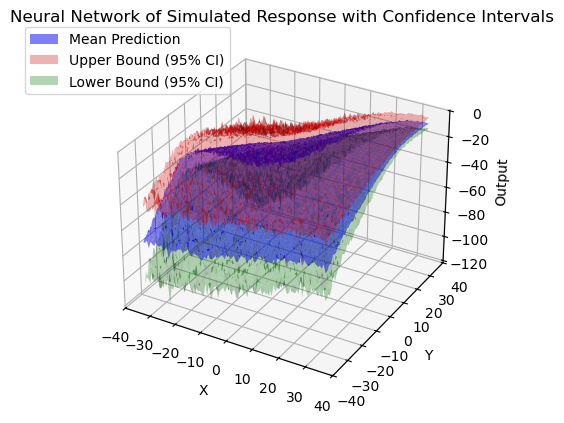

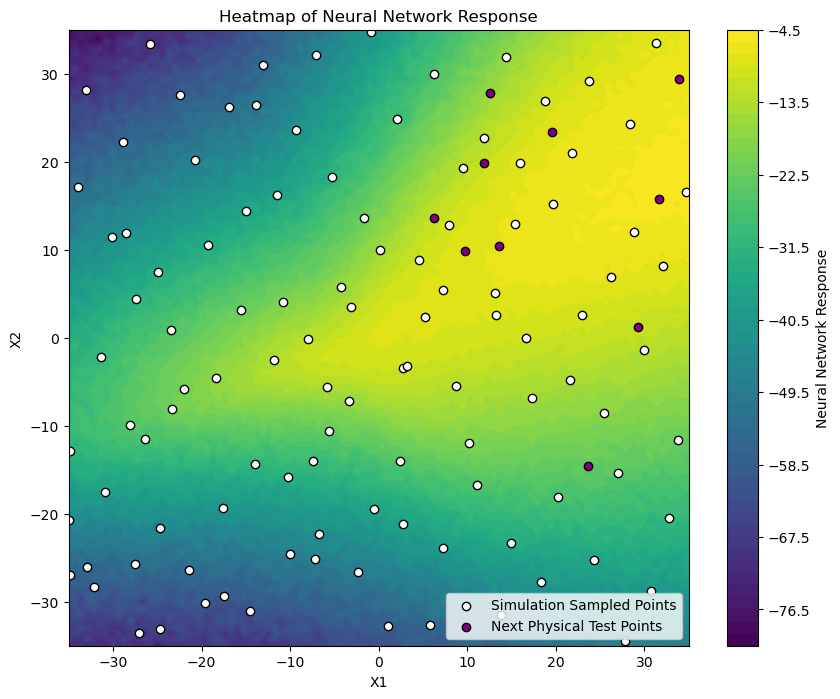

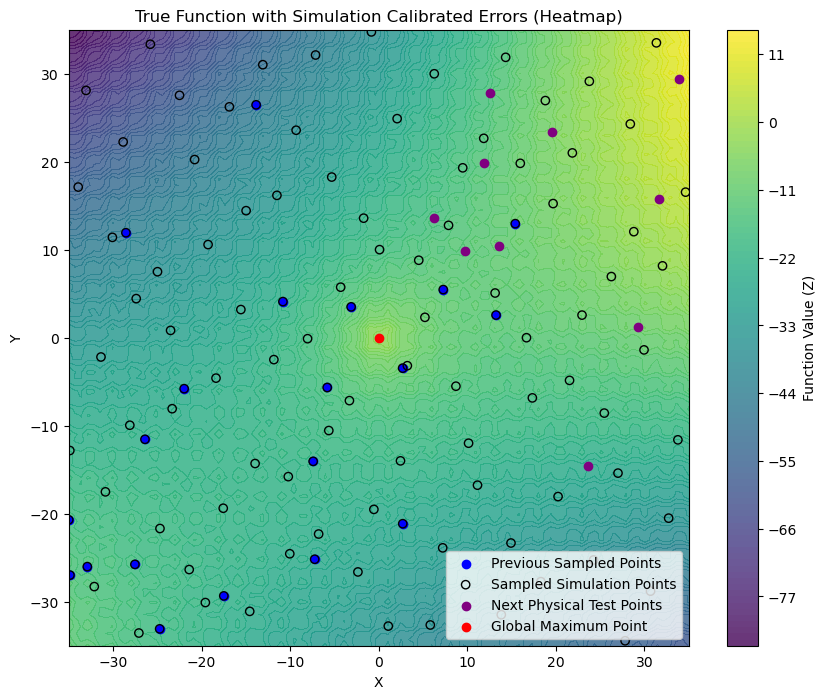

In [ ]:
df = perform_iteration(df)

[ 3.96462507 -3.46303361]


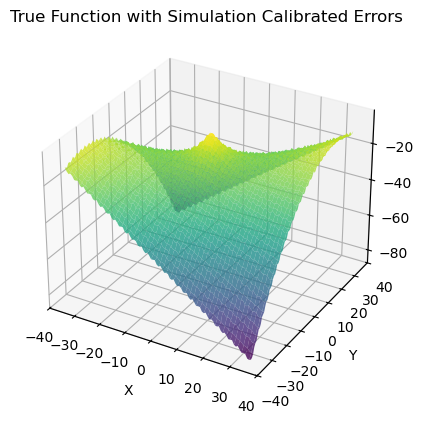

Best hyperparameters:
num_layers: 2
num_units: 69
learning_rate: 0.1
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step - loss: 6348.0420
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5451.9795
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3803.5964
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4323.8682
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3457.5886
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3143.9614
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3375.4065
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3461.1377
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3311.5413
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3078.5625
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3001.1143
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3092.1245
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3065.9

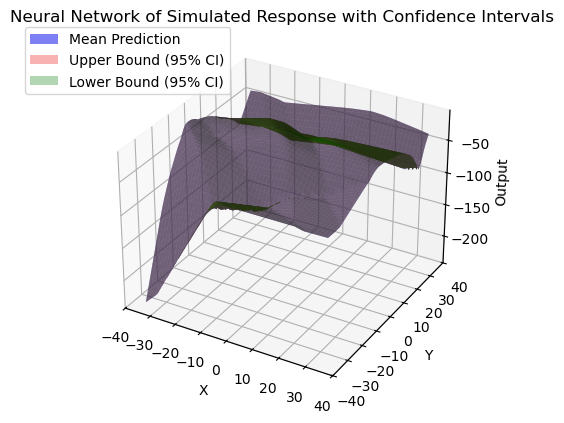

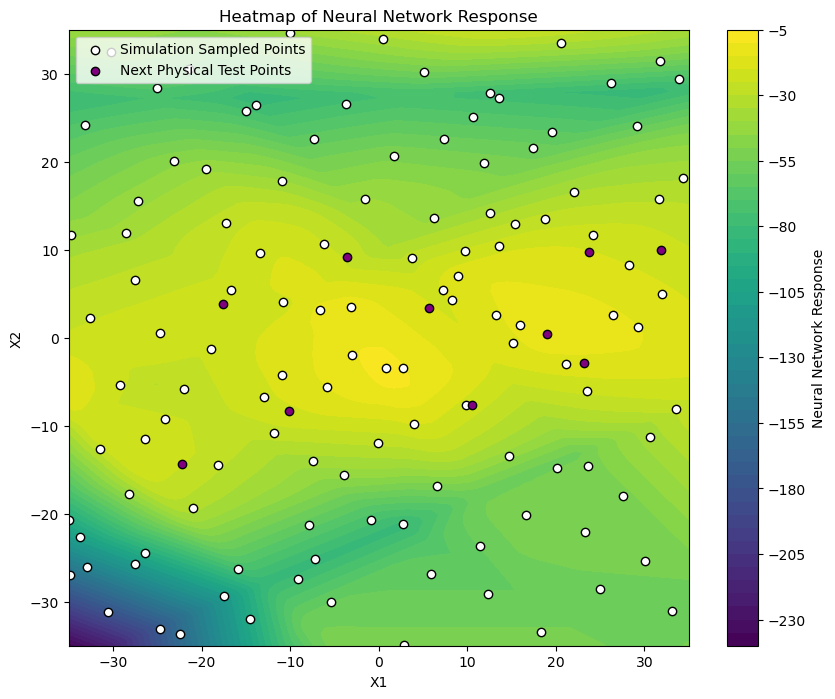

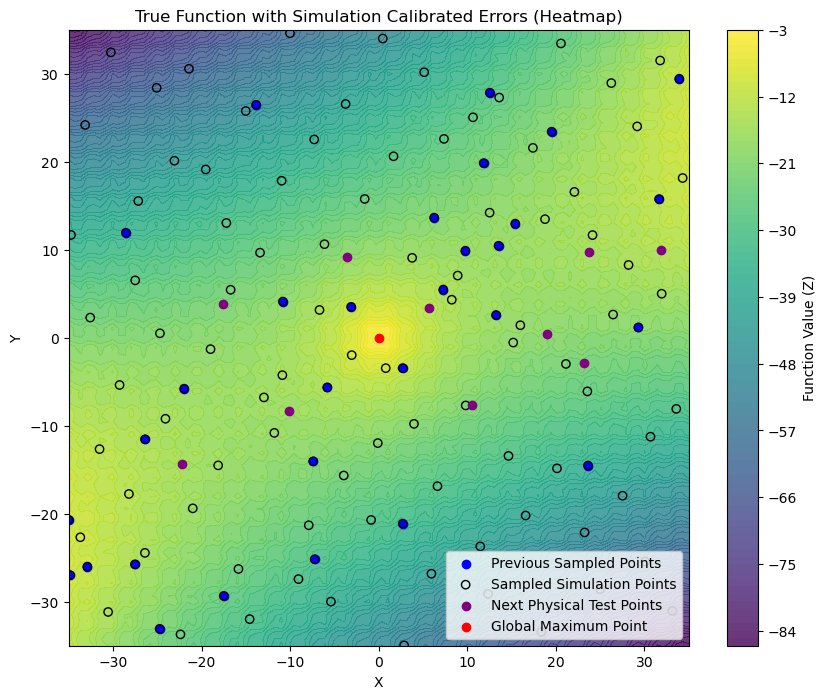

            x          y          z         a         b       sim_z  \
0   -5.808460  -5.656384 -15.447675  3.964625 -3.463034  -25.339919   
1   15.422715  12.965365 -20.539782  3.964625 -3.463034  -61.111031   
2  -34.991994 -20.688343 -21.311133  3.964625 -3.463034 -135.226300   
3  -13.836720  26.468221 -21.753684  3.964625 -3.463034 -244.711261   
4  -24.727088 -33.082868 -21.133971  3.964625 -3.463034 -328.743550   
5  -28.536298  11.932726 -21.439708  3.964625 -3.463034  -80.708895   
6  -21.961785  -5.788664 -20.096030  3.964625 -3.463034  -31.285395   
7  -10.810749   4.108288 -17.005695  3.964625 -3.463034  -25.882726   
8   -7.226277 -25.172914 -20.852178  3.964625 -3.463034 -206.039057   
9    2.717171 -21.132896 -20.500723  3.964625 -3.463034 -154.757343   
10 -34.853321 -26.974340 -20.415407  3.964625 -3.463034 -217.231037   
11 -26.385910 -11.543212 -21.920613  3.964625 -3.463034  -58.593628   
12   2.706855  -3.455864 -11.416266  3.964625 -3.463034  -14.646203   
13 -32

In [ ]:
df = perform_iteration(df)
print(df)

In [ ]:
df = perform_iteration(df)
print(df)